In [1]:
from dataset import YouCookII
from dataset import collate_fn
from torch.utils.data import DataLoader
from loss import loss_RA_MIL
from transformers import get_linear_schedule_with_warmup

import numpy as np
import torch
import matplotlib.pyplot as plt

def train(model, num_actions, batch_size, epochs=25, lr=0.001, y=0.5):
    dataset = YouCookII(num_actions, "/h/sagar/ece496-capstone/datasets/ycii")
    train_size = int(len(dataset) * (2/3))
    valid_size = int(len(dataset) - train_size)
    
    train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer, int(0.2*epochs), epochs)

    train_loss = np.zeros(epochs)
    valid_loss = np.zeros(epochs)
    
    model.train()
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0
        for data in train_dataloader:
            _, bboxes_tensor, features_tensor, steps_list, _, entity_count_list, _, _ = data
            batch_size = len(data[0])
            
            # Zero out any gradients.
            optimizer.zero_grad()

            # Run inference (forward pass).
            loss_E, loss_V, loss_R, _, _, _, _, _ = model(batch_size, num_actions + 1, steps_list, features_tensor, bboxes_tensor, entity_count_list)

            # Loss from alignment.
            loss_ = loss_RA_MIL(y, loss_R, loss_E, loss_V)

            # Backpropagation (backward pass).
            loss_.backward()

            # Update parameters.
            optimizer.step()
            
            epoch_loss += loss_
            num_batches += 1
        
        #learning rate schedule
        #update after each epoch
        scheduler.step()
        epoch_loss = epoch_loss / num_batches
        
        # Save loss and accuracy at each epoch, plot (and checkpoint).
        train_loss[epoch] = epoch_loss
        valid_loss[epoch] = get_validation_loss(num_actions, y, valid_dataloader)
        
        #after epoch completes
        print("Epoch {} - Train Loss: {}, Validation Loss: {}".format(epoch + 1, train_loss[epoch], valid_loss[epoch]))
    
    plt.plot(train_loss, label='train loss')
    plt.plot(valid_loss, label='valid loss')
    plt.legend()
    plt.show()
        
    return train_loss, valid_loss

def get_validation_loss(num_actions, y, valid_dataloader):
    epoch_loss = 0.0
    num_batches = 0
        
    with torch.no_grad():
        for data in valid_dataloader:
            _, bboxes_tensor, features_tensor, steps_list, _, entity_count_list, _, _ = data
            batch_size = len(data[0])

            # Run inference (forward pass).
            loss_E, loss_V, loss_R, _, _, _, _, _ = model(batch_size, num_actions + 1, steps_list, features_tensor, bboxes_tensor, entity_count_list)

            # Loss from alignment.
            loss_ = loss_RA_MIL(y, loss_R, loss_E, loss_V)
            
            epoch_loss += loss_
            num_batches += 1
            
    epoch_loss = epoch_loss / num_batches
    
    return epoch_loss

In [2]:
from model import Model

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(device)
train_loss, valid_loss = train(model, 8, 2, epochs=50, lr=1e-4)

Epoch 0 - Train Loss: 2070.474609375, Validation Loss: 2038.240478515625
Epoch 1 - Train Loss: 1918.0968017578125, Validation Loss: 1740.845947265625
Epoch 2 - Train Loss: 1501.3858642578125, Validation Loss: 1731.0189208984375
Epoch 3 - Train Loss: 1491.7537841796875, Validation Loss: 1617.2679443359375
Epoch 4 - Train Loss: 1338.4691162109375, Validation Loss: 1660.1376953125
Epoch 5 - Train Loss: 1145.9033203125, Validation Loss: 1385.3720703125
Epoch 6 - Train Loss: 1062.0029296875, Validation Loss: 1952.4287109375
Epoch 7 - Train Loss: 1104.8785400390625, Validation Loss: 1766.4822998046875
Epoch 8 - Train Loss: 834.771240234375, Validation Loss: 1004.1988525390625
Epoch 9 - Train Loss: 688.8241577148438, Validation Loss: 1049.519287109375
Epoch 10 - Train Loss: 1044.1689453125, Validation Loss: 1849.556884765625
Epoch 11 - Train Loss: 840.4761962890625, Validation Loss: 1284.927978515625
Epoch 12 - Train Loss: 656.632080078125, Validation Loss: 710.166015625
Epoch 13 - Train Loss

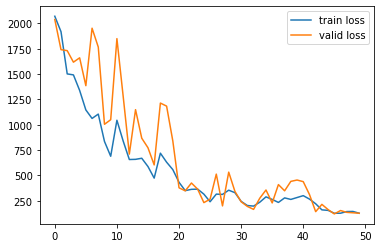